In [58]:
pip install moexalgo

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Fedor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [59]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Looking in indexes: https://download.pytorch.org/whl/cu128Note: you may need to restart the kernel to use updated packages.



ERROR: Could not find a version that satisfies the requirement torchvision (from versions: none)
ERROR: No matching distribution found for torchvision
You should consider upgrading via the 'c:\Users\Fedor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
from moexalgo import Ticker
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader

In [325]:
imoex = Ticker('IMOEX') #Capitalisation of top 50 russian companies
moexeu = Ticker('MOEXEU') #Electroenergy
mscxm = Ticker('MCXSM') #Medium and small level of capitalisation (companies)

#historical data
hist_data_imoex = imoex.candles(start='2015-01-01', end='2024-12-31', period='1d')
hist_data_moexeu = moexeu.candles(start='2015-01-01', end='2024-12-31', period='1d')
hist_data_mscxm = mscxm.candles(start='2015-01-01', end='2024-12-31', period='1d')

df_imoex = pd.DataFrame(hist_data_imoex)
df_moexeu = pd.DataFrame(hist_data_moexeu)
df_mscxm = pd.DataFrame(hist_data_mscxm)

print(df_imoex.head())
print(df_moexeu.head())
print(df_mscxm.head())

      open    close     high      low         value  volume      begin  \
0  1394.66  1435.66  1438.91  1390.53  1.532069e+10     0.0 2015-01-05   
1  1435.39  1480.73  1481.35  1430.47  2.126881e+10     0.0 2015-01-06   
2  1482.12  1547.39  1564.87  1481.93  3.550506e+10     0.0 2015-01-08   
3  1547.61  1515.37  1557.96  1496.17  2.722306e+10     0.0 2015-01-09   
4  1515.23  1513.22  1534.74  1503.49  2.341906e+10     0.0 2015-01-12   

                  end  
0 2015-01-05 23:59:59  
1 2015-01-06 23:59:59  
2 2015-01-08 23:59:59  
3 2015-01-09 23:59:59  
4 2015-01-12 23:59:59  
     open   close    high     low        value  volume      begin  \
0  795.66  806.48  806.61  789.00  265095005.0     0.0 2015-01-05   
1  806.65  812.13  814.71  802.86  289490613.0     0.0 2015-01-06   
2  812.48  828.76  829.53  812.48  433346658.0     0.0 2015-01-08   
3  828.91  819.23  832.28  811.41  362992620.0     0.0 2015-01-09   
4  818.19  810.25  821.27  807.25  401548116.0     0.0 2015-01-12 

**DLWR**

In [4]:
def locally_weighted_regression(x, y, x_new, frac=0.2, degree=1):
    weights = np.exp(-(x - x_new)**2 / (2 * (frac * len(x))**2))
    W = np.diag(weights)
    X = np.vander(x - x_new, degree + 1)
    theta = linalg.pinv(X.T @ W @ X) @ X.T @ W @ y
    return theta[1]

def dynamic_lwr(data, window=10, frac=0.2):
    n = len(data)
    trend = np.zeros(n)
    for i in range(n):
        start = max(0, i - window + 1)
        x = np.arange(start, i + 1)
        y = data[start:i + 1]
        trend[i] = locally_weighted_regression(x, y, i, frac)
    return trend

def dlwr_trend_separation(data, separations=3, window=10, frac=0.2):
    trends = []
    residuals = data.copy()
    for _ in range(separations):
        trend = dynamic_lwr(residuals, window, frac)
        trends.append(trend)
        residuals = residuals - trend
    return trends, residuals

In [326]:
window_size = 10
frac_param = 0.2
separations = 3

dates_imoex = df_imoex['begin'].values
target_imoex = df_imoex['close'].values

dates_moexeu = df_moexeu['begin'].values
target_moexeu = df_moexeu['close'].values

dates_mscxm = df_mscxm['begin'].values
target_mscxm = df_mscxm['close'].values

trends_imoex, noise_imoex = dlwr_trend_separation(target_imoex, window=window_size, frac=frac_param, separations=separations)
trends_moexeu, noise_moexeu = dlwr_trend_separation(target_moexeu, window=window_size, frac=frac_param, separations=separations)
trends_mscxm, noise_mscxm = dlwr_trend_separation(target_mscxm, window=window_size, frac=frac_param, separations=separations)

print(target_imoex[0])
print(trends_imoex[0][0])
#Means
print("Means:")
print(f"Mean f0: {np.mean(trends_imoex[0]):.4f}")
print(f"Mean f1: {np.mean(trends_imoex[1]):.4f}")
print(f"Mean f2: {np.mean(trends_imoex[2]):.4f}")
print(f"Mean noise: {np.mean(noise_imoex):.4f}")

#Recunstruction to test whether its close
reconstructed = trends_imoex[0] + trends_imoex[1] + trends_imoex[2] + noise_imoex
reconstruction_error = np.max(np.abs(reconstructed - target_imoex))
print(f"\nMax error reconstruction: {reconstruction_error:.2e}")

1435.66
1435.66
Means:
Mean f0: 2559.1123
Mean f1: 0.0080
Mean f2: 0.0041
Mean noise: 0.0005

Max error reconstruction: 9.09e-13


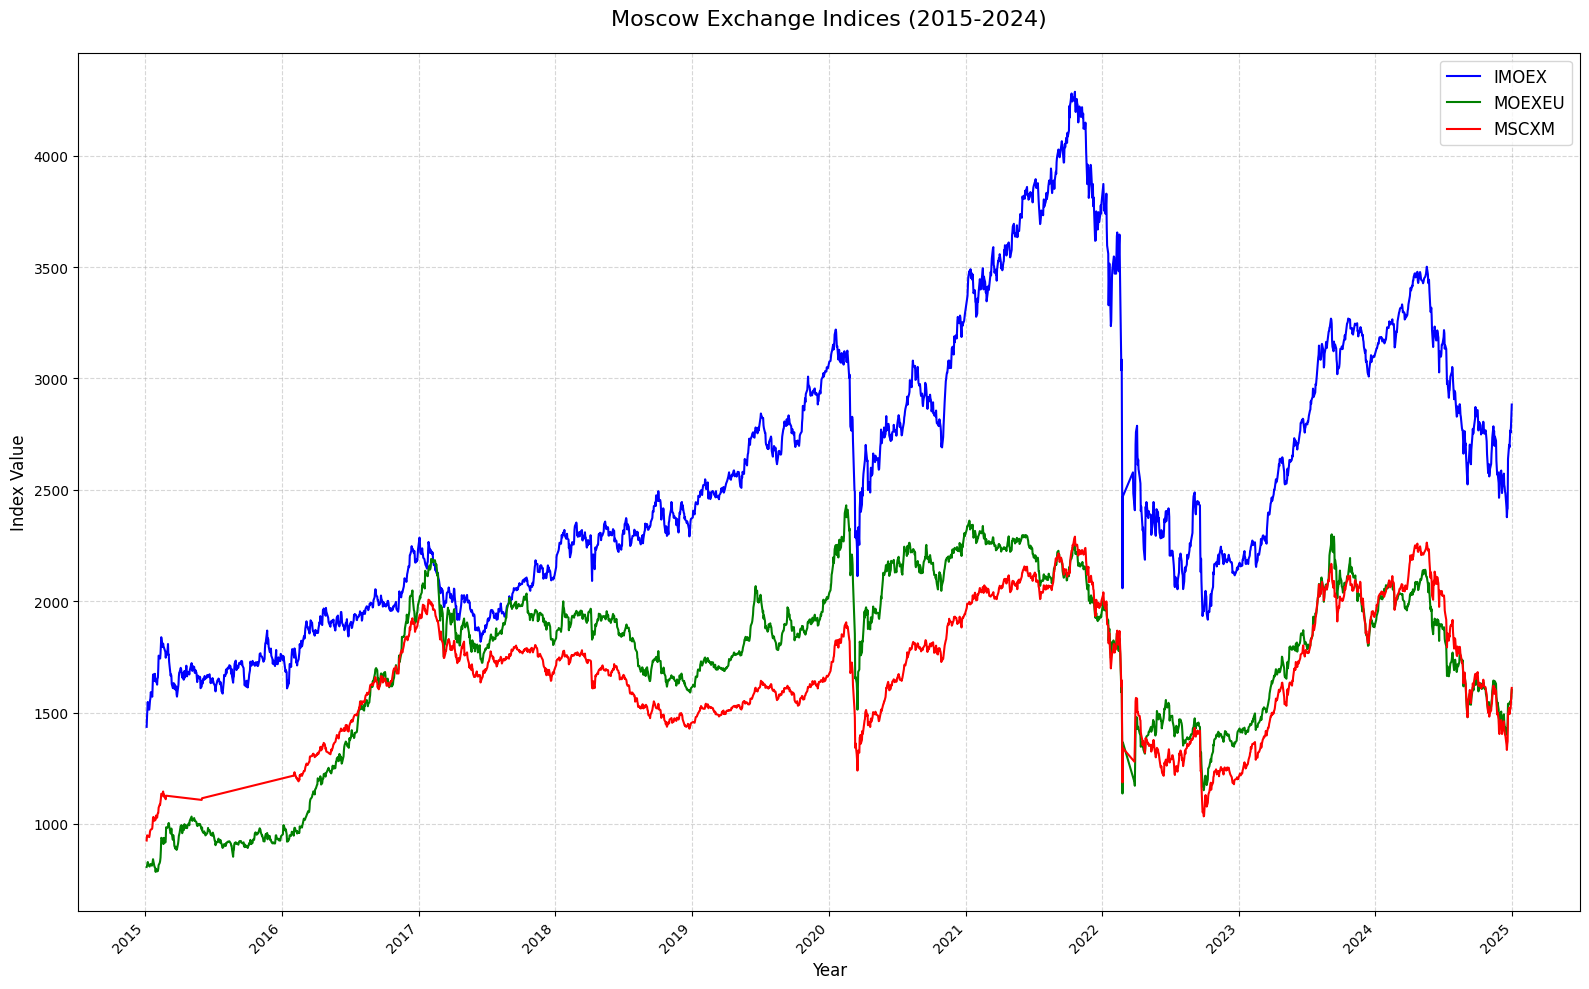

In [64]:
plt.figure(figsize=(16, 10))


plt.plot(dates_imoex, target_imoex, label="IMOEX", color="blue", linewidth=1.5)
plt.plot(dates_moexeu, target_moexeu, label="MOEXEU", color="green", linewidth=1.5)
plt.plot(dates_mscxm, target_mscxm, label="MSCXM", color="red", linewidth=1.5)

plt.title("Moscow Exchange Indices (2015-2024)", fontsize=16, pad=20)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Index Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(fontsize=12)

years = range(2015, 2026)
plt.xticks(
    [pd.Timestamp(f"{year}-01-01") for year in years],
    [str(year) for year in years],
    rotation=45,
    ha="right"
)

plt.tight_layout()
plt.savefig("moex_indices_plot.png", dpi=300, bbox_inches="tight")
plt.show()

**Visualisation IMOEX**

In [65]:
f0_last_imoex = trends_imoex[0][-60:]
f1_last_imoex = trends_imoex[1][-60:]
f2_last_imoex = trends_imoex[2][-60:]
d0_last_imoex = (target_imoex - trends_imoex[0])[-60:]
d1_last_imoex = (target_imoex - trends_imoex[0] - trends_imoex[1])[-60:]
d2_last_imoex = noise_imoex[-60:]
np.mean(trends_imoex)

np.float64(853.0414565899623)

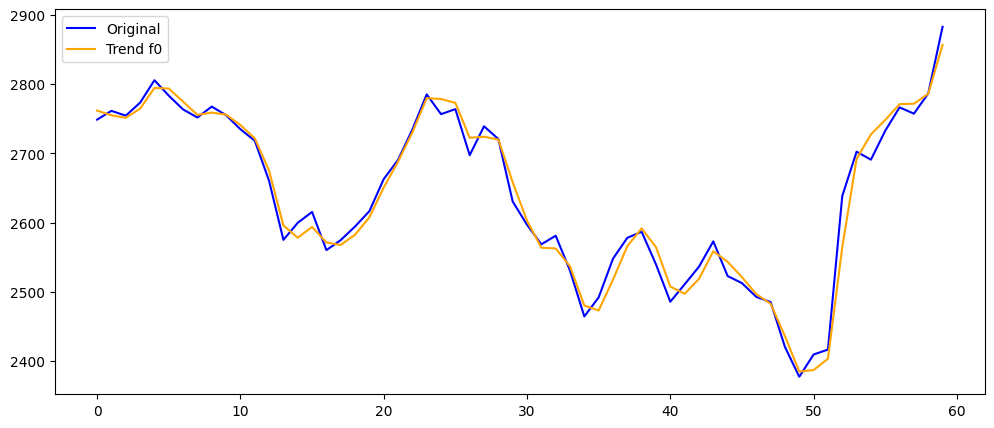

In [66]:
plt.figure(figsize=(12, 5))
plt.plot(target_imoex[-60:], label='Original', color='blue')
plt.plot(f0_last_imoex, label='Trend f0', color='orange')
plt.legend()
plt.show()

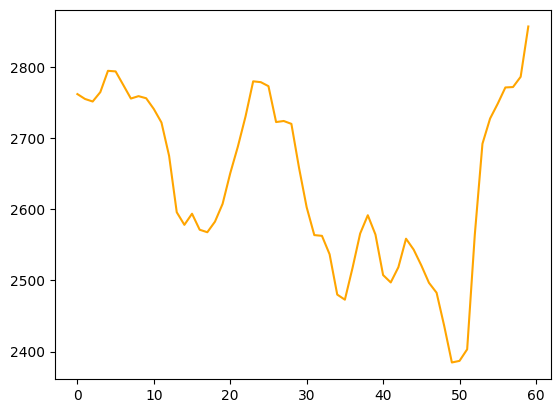

In [67]:
plt.plot(f0_last_imoex, color='orange', label='f0')

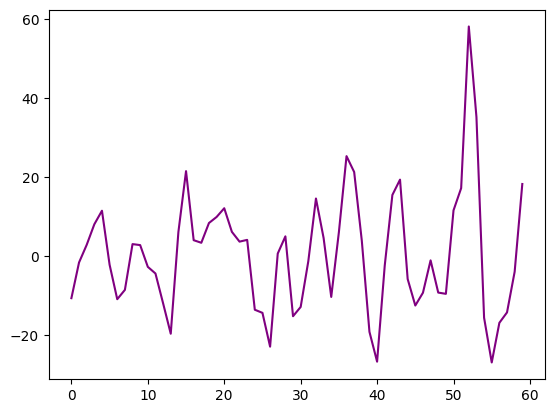

In [68]:
plt.plot(f1_last_imoex, color='purple', label='f1')

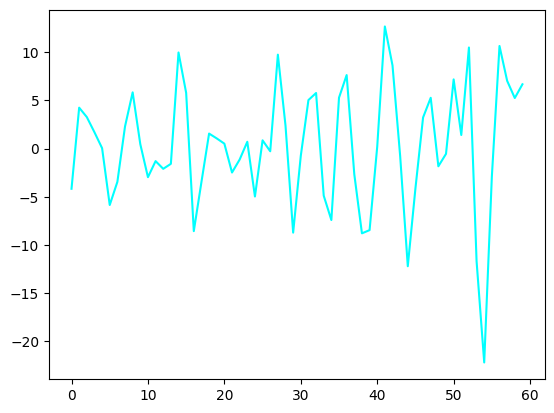

In [69]:
plt.plot(f2_last_imoex, color='cyan', label='f2')

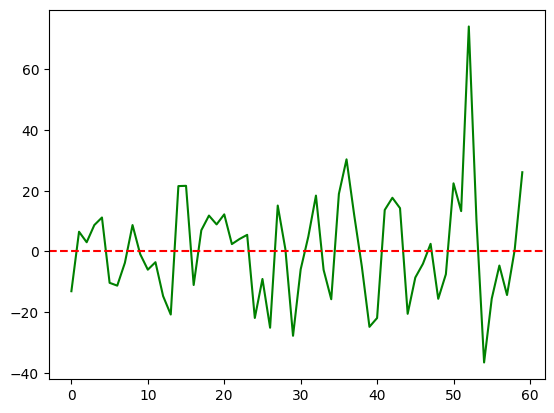

In [70]:
plt.plot(d0_last_imoex, color='green', label='d0')
plt.axhline(0, color='red', linestyle='--')

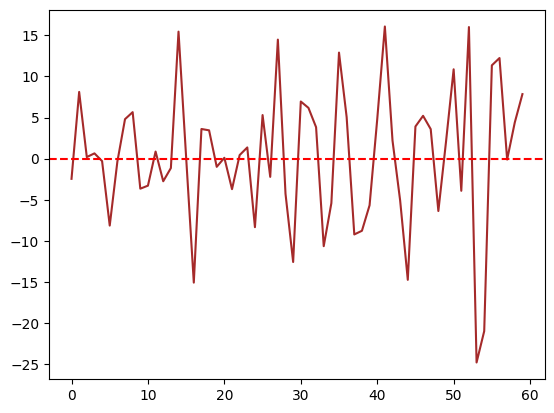

In [71]:
plt.plot(d1_last_imoex, color='brown', label='d1')
plt.axhline(0, color='red', linestyle='--')

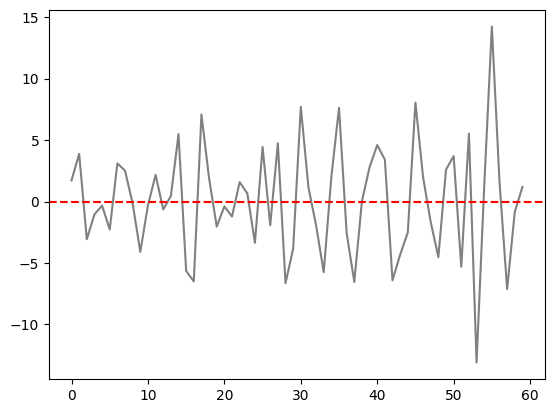

In [72]:
plt.plot(d2_last_imoex, color='gray', label='d2')
plt.axhline(0, color='red', linestyle='--')

**Visualisation MOEXEU**

In [73]:
f0_last_moexeu = trends_moexeu[0][-60:]
f1_last_moexeu = trends_moexeu[1][-60:]
f2_last_moexeu = trends_moexeu[2][-60:]
d0_last_moexeu = (target_moexeu - trends_moexeu[0])[-60:]
d1_last_moexeu = (target_moexeu - trends_moexeu[0] - trends_moexeu[1])[-60:]
d2_last_moexeu = noise_moexeu[-60:]
np.mean(trends_moexeu)

np.float64(578.3306505213262)

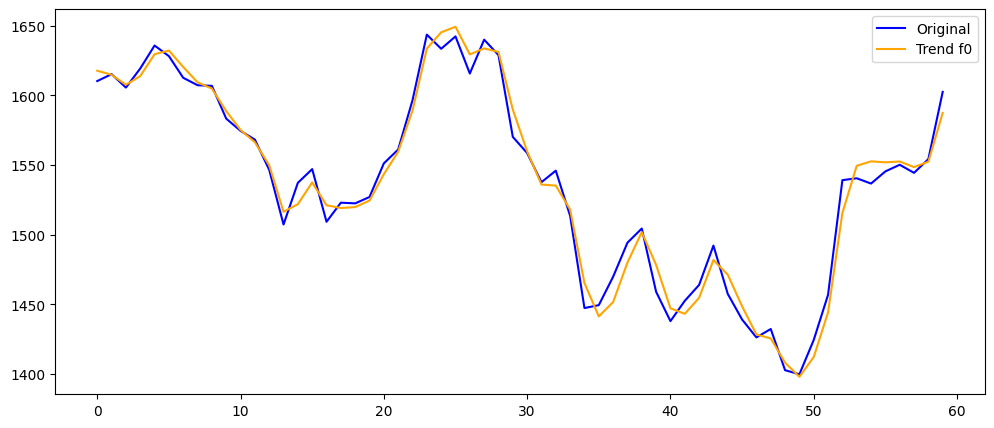

In [74]:
plt.figure(figsize=(12, 5))
plt.plot(target_moexeu[-60:], label='Original', color='blue')
plt.plot(f0_last_moexeu, label='Trend f0', color='orange')
plt.legend()
plt.show()

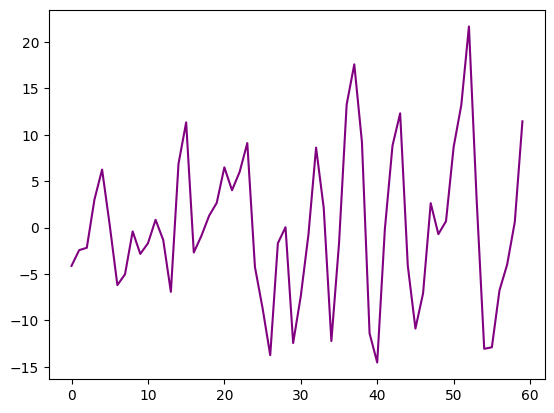

In [75]:
plt.plot(f1_last_moexeu, color='purple', label='f1')

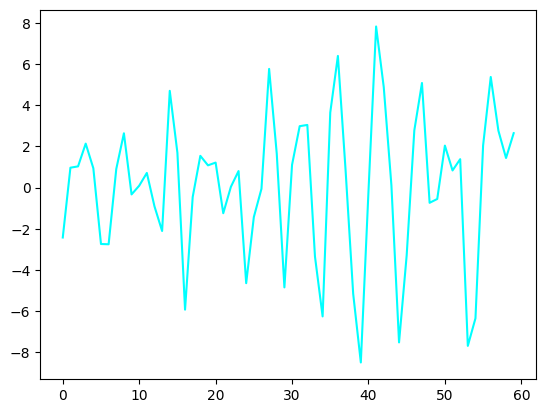

In [76]:
plt.plot(f2_last_moexeu, color='cyan', label='f2')

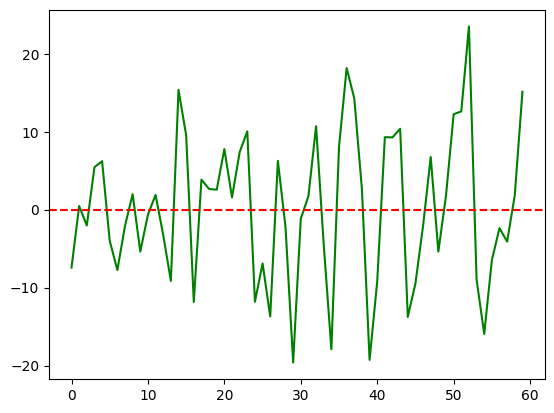

In [77]:
plt.plot(d0_last_moexeu, color='green', label='d0')
plt.axhline(0, color='red', linestyle='--')

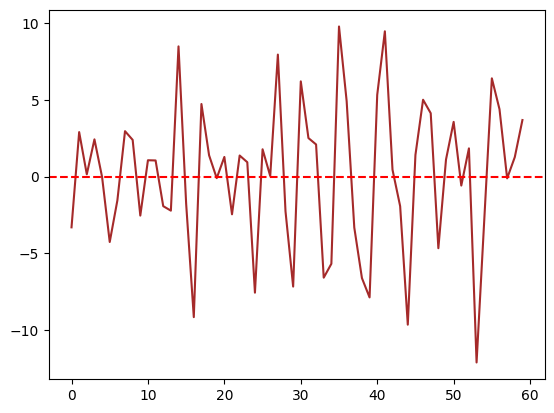

In [78]:
plt.plot(d1_last_moexeu, color='brown', label='d1')
plt.axhline(0, color='red', linestyle='--')

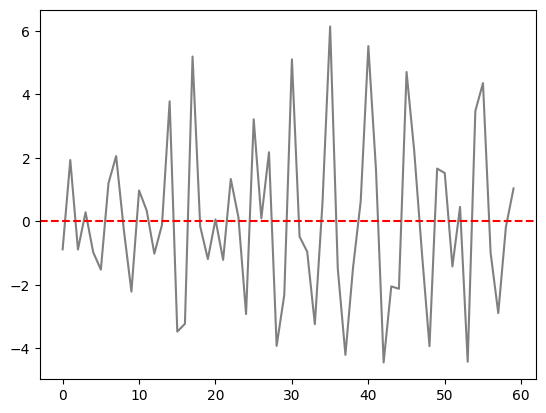

In [79]:
plt.plot(d2_last_moexeu, color='gray', label='d2')
plt.axhline(0, color='red', linestyle='--')

**Visualisasion MSCXM**

In [80]:
f0_last_mscxm = trends_mscxm[0][-60:]
f1_last_mscxm = trends_mscxm[1][-60:]
f2_last_mscxm = trends_mscxm[2][-60:]
d0_last_mscxm = (target_mscxm - trends_mscxm[0])[-60:]
d1_last_mscxm = (target_mscxm - trends_mscxm[0] - trends_mscxm[1])[-60:]
d2_last_mscxm = noise_mscxm[-60:]
np.mean(trends_mscxm)

np.float64(562.8791958610178)

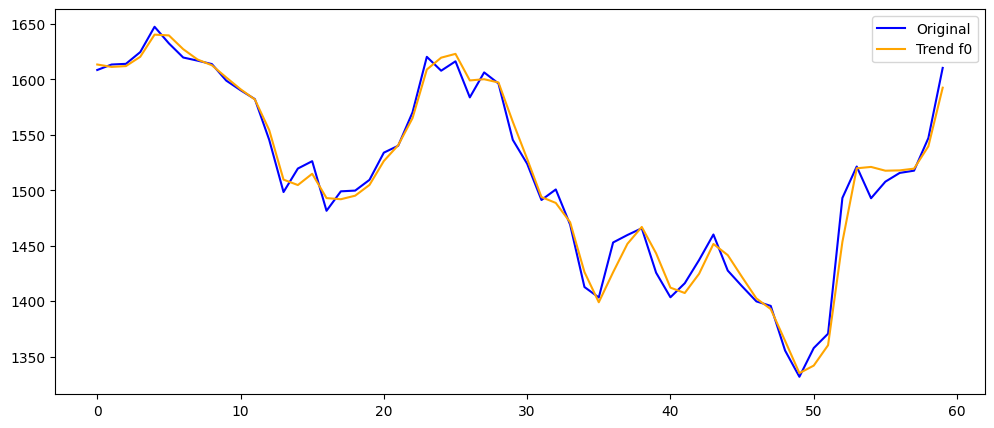

In [81]:
plt.figure(figsize=(12, 5))
plt.plot(target_mscxm[-60:], label='Original', color='blue')
plt.plot(f0_last_mscxm, label='Trend f0', color='orange')
plt.legend()
plt.show()

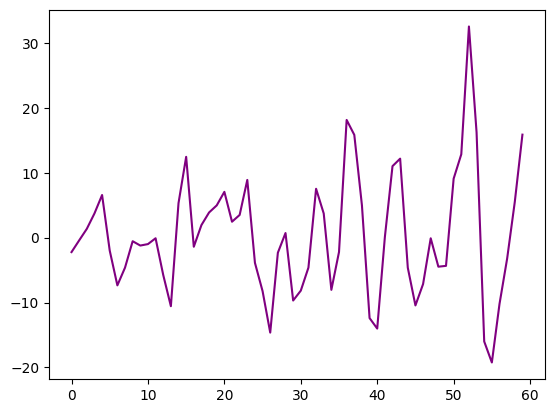

In [82]:
plt.plot(f1_last_mscxm, color='purple', label='f1')

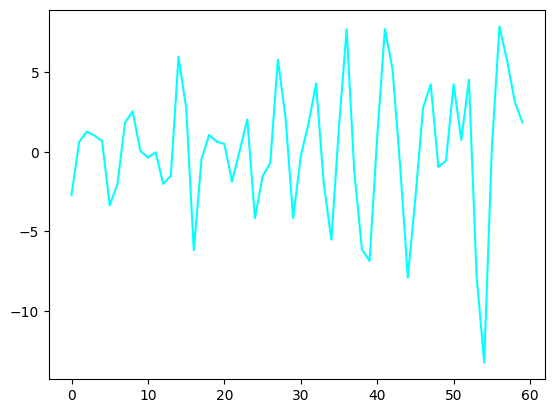

In [83]:
plt.plot(f2_last_mscxm, color='cyan', label='f2')

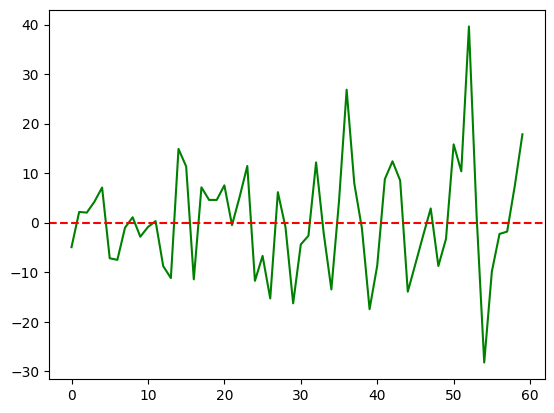

In [84]:
plt.plot(d0_last_mscxm, color='green', label='d0')
plt.axhline(0, color='red', linestyle='--')

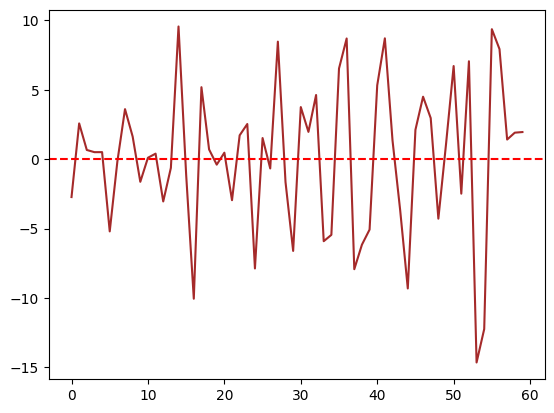

In [85]:
plt.plot(d1_last_mscxm, color='brown', label='d1')
plt.axhline(0, color='red', linestyle='--')

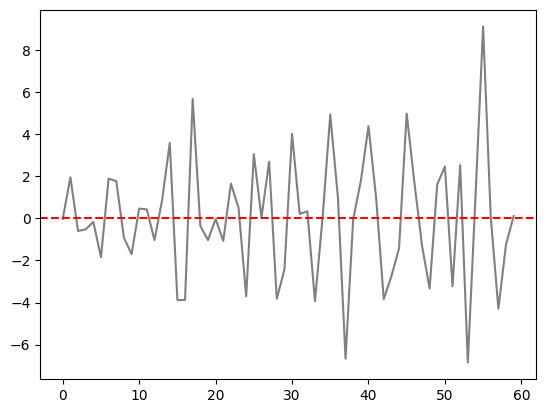

In [86]:
plt.plot(d2_last_mscxm, color='gray', label='d2')
plt.axhline(0, color='red', linestyle='--')

**Checking autocorellation of noise**

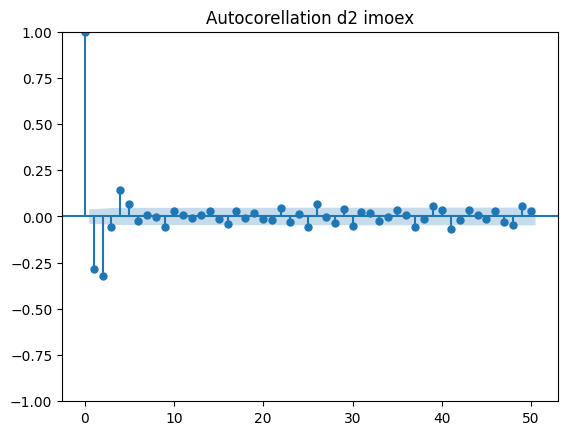

In [87]:
plot_acf(target_imoex - trends_imoex[0] - trends_imoex[1] - trends_imoex[2], lags=50)
plt.title("Autocorellation d2 imoex")
plt.show()

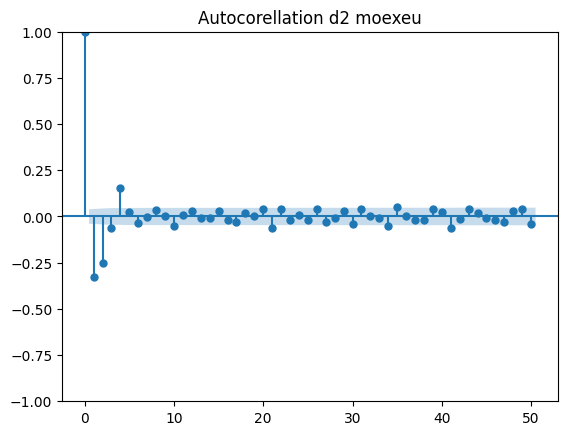

In [88]:
plot_acf(target_moexeu - trends_moexeu[0] - trends_moexeu[1] - trends_moexeu[2], lags=50)
plt.title("Autocorellation d2 moexeu")
plt.show()

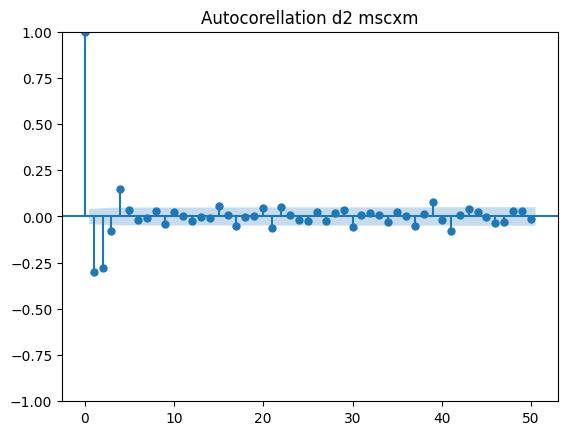

In [89]:
plot_acf(target_mscxm - trends_mscxm[0] - trends_mscxm[1] - trends_mscxm[2], lags=50)
plt.title("Autocorellation d2 mscxm")
plt.show()

**Preparing LSTM**

In [6]:
scaler = MinMaxScaler()

In [7]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"MAE": mae, "RMSE": rmse, "R2": r2, "MAPE %": mape} 

def plot_training(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Train Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title(f'{model_name} Training History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    os.makedirs("training_plots", exist_ok=True)
    plot_path = f"training_plots/{model_name}_training.png"
    plt.savefig(plot_path)
    plt.close()
    
    print(f"Training plot saved to {plot_path}")


**LSTM**

In [8]:
class BaseLSTM(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True)
        self.lstm3 = nn.LSTM(128, 128, batch_first=True)
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x, _ = self.lstm1(x)  
        x, _ = self.lstm2(x)  
        x, _ = self.lstm3(x)  
        x = x[:, -1, :] 
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)  

In [ ]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_size=1):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size, 64, batch_first=True,)
        self.lstm2 = nn.LSTM(64, 128, batch_first=True)
        self.lstm3 = nn.LSTM(128, 128, batch_first=True)
        
        self.attention = nn.Sequential(
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 1, bias=False)
        )
        
        self.fc1 = nn.Linear(128, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)  
        lstm_out, _ = self.lstm3(x)  
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  
        context = (attention_weights * lstm_out).sum(dim=1)  
        x = self.relu(self.fc1(context))  
        x = self.dropout(x)
        return self.fc2(x), attention_weights.squeeze(-1)  

In [364]:
class DLWR_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.model_f0 = BaseLSTM(input_size=1)
        self.model_f1 = BaseLSTM(input_size=1)
        self.model_f2 = BaseLSTM(input_size=1)
        self.model_d2 = BaseLSTM(input_size=1)  
        
        self.fc = nn.Sequential(
            nn.Linear(4, 64),  
            nn.ReLU(),
            nn.Dropout(0.2),  
            nn.Linear(64, 1))
    
    def forward(self, x_f0, x_f1, x_f2, x_d2):
        pred_f0 = self.model_f0(x_f0)
        pred_f1 = self.model_f1(x_f1)
        pred_f2 = self.model_f2(x_f2)
        pred_d2 = self.model_d2(x_d2)
        
        combined = torch.cat([pred_f0, pred_f1, pred_f2, pred_d2], dim=1)
        return self.fc(combined)

In [10]:
class DLWR_Attention_LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64):
        super().__init__()
        self.lstm_f0 = AttentionLSTM(input_size, hidden_size)
        self.lstm_f1 = AttentionLSTM(input_size, hidden_size)
        self.lstm_f2 = AttentionLSTM(input_size, hidden_size)
        self.fc = nn.Linear(3, 1)  
    
    def forward(self, x_f0, x_f1, x_f2):
        pred_f0, _ = self.lstm_f0(x_f0)
        pred_f1, _ = self.lstm_f1(x_f1)
        pred_f2, _ = self.lstm_f2(x_f2)
        combined = torch.cat([pred_f0, pred_f1, pred_f2], dim=1)
        return self.fc(combined)

In [11]:
def train_model(model, train_loader, val_loader, epochs=100, model_name="LSTM"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())

    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            if isinstance(outputs, tuple):  #for Attention_LSTM
                outputs = outputs[0]
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                if isinstance(outputs, tuple):  #for Attention_LSTM
                    outputs = outputs[0]
                val_loss += criterion(outputs, y_val).item() * X_val.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}')

    plot_training(history, model_name)
    
    return model, history  

In [235]:
def train_dlwr_model(model, train_loaders, val_loaders, epochs=100, model_name="DLWR_LSTM"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    
    history = {'train_loss': [], 'val_loss': []}
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        iterators = {name: iter(loader) for name, loader in train_loaders.items()}
        num_batches = min(len(loader) for loader in train_loaders.values())
        
        for _ in range(num_batches):
            batch = {name: next(it) for name, it in iterators.items()}

            X_batch = {name: data[0].to(device) for name, data in batch.items()}
            y_batch = batch['f0'][1].to(device)  
            
            optimizer.zero_grad()

            if isinstance(model, DLWR_LSTM): 
                outputs = model(X_batch['f0'], X_batch['f1'], X_batch['f2'], X_batch['d2'])
            
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_iterators = {name: iter(loader) for name, loader in val_loaders.items()}
            num_val_batches = min(len(loader) for loader in val_loaders.values())
            
            for _ in range(num_val_batches):
                val_batch = {name: next(it) for name, it in val_iterators.items()}
                X_val = {name: data[0].to(device) for name, data in val_batch.items()}
                y_val = val_batch['f0'][1].to(device)
                
                if isinstance(model, DLWR_LSTM):
                    outputs = model(X_val['f0'], X_val['f1'], X_val['f2'], X_val['d2'])
                
                val_loss += criterion(outputs, y_val).item()
        
        history['train_loss'].append(train_loss/num_batches)
        history['val_loss'].append(val_loss/num_val_batches)
        
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {history["train_loss"][-1]:.4f} | Val Loss: {history["val_loss"][-1]:.4f}')
    
    plot_training(history, model_name)
    return model, history

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [287]:
#saving graphs
os.makedirs("training_plots", exist_ok=True)

components_imoex = {
    'f0': trends_imoex[0], 
    'f1': trends_imoex[1],
    'f2': trends_imoex[2],
    'd2': noise_imoex
}

scalers = {}
for i, (name, data) in enumerate(components_imoex.items()):
    scalers[name] = MinMaxScaler()
    components_imoex[name] = scalers[name].fit_transform(data.reshape(-1, 1)).flatten()

print("Максимумы после нормализации:")
for name in components_imoex:
    print(f"{name}: {components_imoex[name].max():.4f}")

seq_length = 10

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])
    return np.array(sequences), np.array(targets)

def create_component_loaders(components, seq_length=10, batch_size=16):
    loaders = {}
    for name, data in components.items():
        X, y = create_sequences(data, seq_length)
        dataset = TensorDataset(torch.FloatTensor(X).unsqueeze(-1), 
                            torch.FloatTensor(y).unsqueeze(-1))
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loaders[name] = loader
    return loaders

scaled_original = scaler.fit_transform(target_imoex.reshape(-1, 1)).flatten()
X_original, y_original = create_sequences(scaled_original, seq_length)

train_DLWR_loaders = create_component_loaders({k: v[:int(0.7*len(v))] for k,v in components_imoex.items()})
val_DLWR_loaders = create_component_loaders({k: v[int(0.7*len(v)):int(0.85*len(v))] for k,v in components_imoex.items()})
test_DLWR_loaders = create_component_loaders({k: v[int(0.85*len(v)):] for k,v in components_imoex.items()})

Максимумы после нормализации:
f0: 1.0000
f1: 1.0000
f2: 1.0000
d2: 1.0000


In [288]:
def train_val_test_split(X, y, train_ratio=0.7, val_ratio=0.15):
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

(X_orig_train, y_orig_train), (X_orig_val, y_orig_val), (X_orig_test, y_orig_test) = train_val_test_split(X_original, y_original)

In [33]:
def evaluate_model(model, X_test, y_test, scaler, model_name):
    device = next(model.parameters()).device  
    
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.FloatTensor(X_test).unsqueeze(-1).to(device)
        model_output = model(X_test_tensor)

        if isinstance(model_output, tuple):
            predictions = model_output[0]
        else:
            predictions = model_output
        predictions = predictions.cpu().numpy().flatten()  
    
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    
    metrics = calculate_metrics(y_true, y_pred)
    print(f"\nMetrics for {model_name}:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    return metrics

In [327]:
def to_tensor(X, y):
    return torch.FloatTensor(X).unsqueeze(-1), torch.FloatTensor(y).unsqueeze(-1)

train_orig = TensorDataset(*to_tensor(X_orig_train, y_orig_train))
val_orig = TensorDataset(*to_tensor(X_orig_val, y_orig_val))
train_loader_orig = DataLoader(train_orig, batch_size=16, shuffle=True)
val_loader_orig = DataLoader(val_orig, batch_size=16)

In [257]:
torch.manual_seed(123)
base_lstm = BaseLSTM(input_size=1)
model_lstm, history = train_model(base_lstm, train_loader_orig, val_loader_orig, 
                            epochs=50, model_name="BaseLSTM")


Epoch 1/50 | Train Loss: 0.0282 | Val Loss: 0.0054
Epoch 2/50 | Train Loss: 0.0023 | Val Loss: 0.0039
Epoch 3/50 | Train Loss: 0.0020 | Val Loss: 0.0032
Epoch 4/50 | Train Loss: 0.0020 | Val Loss: 0.0060
Epoch 5/50 | Train Loss: 0.0020 | Val Loss: 0.0029
Epoch 6/50 | Train Loss: 0.0020 | Val Loss: 0.0039
Epoch 7/50 | Train Loss: 0.0017 | Val Loss: 0.0030
Epoch 8/50 | Train Loss: 0.0018 | Val Loss: 0.0033
Epoch 9/50 | Train Loss: 0.0015 | Val Loss: 0.0027
Epoch 10/50 | Train Loss: 0.0015 | Val Loss: 0.0027
Epoch 11/50 | Train Loss: 0.0015 | Val Loss: 0.0028
Epoch 12/50 | Train Loss: 0.0014 | Val Loss: 0.0027
Epoch 13/50 | Train Loss: 0.0015 | Val Loss: 0.0024
Epoch 14/50 | Train Loss: 0.0012 | Val Loss: 0.0026
Epoch 15/50 | Train Loss: 0.0013 | Val Loss: 0.0022
Epoch 16/50 | Train Loss: 0.0012 | Val Loss: 0.0023
Epoch 17/50 | Train Loss: 0.0012 | Val Loss: 0.0019
Epoch 18/50 | Train Loss: 0.0011 | Val Loss: 0.0019
Epoch 19/50 | Train Loss: 0.0011 | Val Loss: 0.0018
Epoch 20/50 | Train L

In [258]:
metrics_base = evaluate_model(model_lstm, X_orig_test, y_orig_test, scaler, "BaseLSTM")


Metrics for BaseLSTM:
MAE: 24.2315
RMSE: 34.6379
R2: 0.9828
MAPE %: 0.8275


In [37]:
torch.save(model_lstm.state_dict(), "lstm_imoex_weights.pth")

In [259]:
torch.manual_seed(123)
attention_lstm = AttentionLSTM(input_size=1)
model_attention_lstm, history = train_model(attention_lstm, train_loader_orig, val_loader_orig, 
                            epochs=77, model_name="AttentionLSTM")

Epoch 1/77 | Train Loss: 0.0274 | Val Loss: 0.0053
Epoch 2/77 | Train Loss: 0.0023 | Val Loss: 0.0041
Epoch 3/77 | Train Loss: 0.0026 | Val Loss: 0.0052
Epoch 4/77 | Train Loss: 0.0020 | Val Loss: 0.0040
Epoch 5/77 | Train Loss: 0.0021 | Val Loss: 0.0044
Epoch 6/77 | Train Loss: 0.0020 | Val Loss: 0.0044
Epoch 7/77 | Train Loss: 0.0020 | Val Loss: 0.0037
Epoch 8/77 | Train Loss: 0.0018 | Val Loss: 0.0040
Epoch 9/77 | Train Loss: 0.0017 | Val Loss: 0.0041
Epoch 10/77 | Train Loss: 0.0019 | Val Loss: 0.0039
Epoch 11/77 | Train Loss: 0.0018 | Val Loss: 0.0043
Epoch 12/77 | Train Loss: 0.0019 | Val Loss: 0.0035
Epoch 13/77 | Train Loss: 0.0022 | Val Loss: 0.0040
Epoch 14/77 | Train Loss: 0.0016 | Val Loss: 0.0039
Epoch 15/77 | Train Loss: 0.0015 | Val Loss: 0.0039
Epoch 16/77 | Train Loss: 0.0015 | Val Loss: 0.0038
Epoch 17/77 | Train Loss: 0.0016 | Val Loss: 0.0045
Epoch 18/77 | Train Loss: 0.0016 | Val Loss: 0.0036
Epoch 19/77 | Train Loss: 0.0015 | Val Loss: 0.0036
Epoch 20/77 | Train L

In [260]:
metrics_attention = evaluate_model(model_attention_lstm, X_orig_test, y_orig_test, scaler, "AttentionLSTM")


Metrics for AttentionLSTM:
MAE: 26.3004
RMSE: 35.5890
R2: 0.9819
MAPE %: 0.8904


In [47]:
torch.save(model_attention_lstm.state_dict(), "a_lstm_imoex_weights.pth")

In [290]:
def evaluate_dlwr_model(model, test_loaders, scaler, model_name="DLWR_LSTM"):
    device = next(model.parameters()).device
    model.eval()
    
    y_true_list = []
    y_pred_list = []
    iterators = {name: iter(loader) for name, loader in test_loaders.items()}
    num_batches = min(len(loader) for loader in test_loaders.values())
    
    with torch.no_grad():
        for _ in range(num_batches):
            batch = {name: next(it) for name, it in iterators.items()}
            
            X_test = {name: data[0].to(device) for name, data in batch.items()}
            y_test = batch['f0'][1].numpy()  
            if isinstance(model, DLWR_LSTM): 
                predictions = model(X_test['f0'], X_test['f1'], X_test['f2'], X_test['d2'])
            
            y_pred_list.extend(predictions.cpu().numpy().flatten())
            y_true_list.extend(y_test.flatten())
    
    y_true = scaler.inverse_transform(np.array(y_true_list).reshape(-1, 1)).flatten()
    y_pred = scaler.inverse_transform(np.array(y_pred_list).reshape(-1, 1)).flatten()
    
    metrics = calculate_metrics(y_true, y_pred)
    print(f"\nMetrics for {model_name}:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    
    return metrics

In [303]:
torch.manual_seed(123)
base_dlwr = DLWR_LSTM()
model_dlwr_lstm, history = train_dlwr_model(base_dlwr, train_DLWR_loaders, val_DLWR_loaders, 
                            epochs=90, model_name="DLWR_LSTM")

Epoch 1/90 | Train Loss: 0.0264 | Val Loss: 0.0033
Epoch 2/90 | Train Loss: 0.0058 | Val Loss: 0.0057
Epoch 3/90 | Train Loss: 0.0045 | Val Loss: 0.0032
Epoch 4/90 | Train Loss: 0.0033 | Val Loss: 0.0030
Epoch 5/90 | Train Loss: 0.0029 | Val Loss: 0.0048
Epoch 6/90 | Train Loss: 0.0027 | Val Loss: 0.0052
Epoch 7/90 | Train Loss: 0.0024 | Val Loss: 0.0029
Epoch 8/90 | Train Loss: 0.0027 | Val Loss: 0.0051
Epoch 9/90 | Train Loss: 0.0022 | Val Loss: 0.0040
Epoch 10/90 | Train Loss: 0.0022 | Val Loss: 0.0028
Epoch 11/90 | Train Loss: 0.0022 | Val Loss: 0.0028
Epoch 12/90 | Train Loss: 0.0023 | Val Loss: 0.0028
Epoch 13/90 | Train Loss: 0.0020 | Val Loss: 0.0023
Epoch 14/90 | Train Loss: 0.0021 | Val Loss: 0.0024
Epoch 15/90 | Train Loss: 0.0019 | Val Loss: 0.0027
Epoch 16/90 | Train Loss: 0.0017 | Val Loss: 0.0021
Epoch 17/90 | Train Loss: 0.0019 | Val Loss: 0.0021
Epoch 18/90 | Train Loss: 0.0017 | Val Loss: 0.0025
Epoch 19/90 | Train Loss: 0.0018 | Val Loss: 0.0022
Epoch 20/90 | Train L

In [304]:
metrics_dlwr = evaluate_dlwr_model(model_dlwr_lstm, test_DLWR_loaders, scaler, "DLWR-LSTM")


Metrics for DLWR-LSTM:
MAE: 30.2258
RMSE: 42.0706
R2: 0.9753
MAPE %: 1.0264


90 - epochs
Metrics for DLWR-LSTM:
MAE: 30.2258
RMSE: 42.0706
R2: 0.9753
MAPE %: 1.0264

In [305]:
torch.save(model_dlwr_lstm.state_dict(), "dlwr_lstm_imoex_weights.pth")

**Testing other indicies**

In [331]:
scaled_original_moexeu = scaler.fit_transform(target_moexeu.reshape(-1, 1)).flatten()
X_original_moexeu, y_original_moexeu = create_sequences(scaled_original_moexeu, seq_length)

components_moexeu = {
    'f0': trends_moexeu[0], 
    'f1': trends_moexeu[1],
    'f2': trends_moexeu[2],
    'd2': noise_moexeu
}

scalers_moexeu= {}
for i, (name, data) in enumerate(components_moexeu.items()):
    scalers_moexeu[name] = MinMaxScaler()
    components_moexeu[name] = scalers_moexeu[name].fit_transform(data.reshape(-1, 1)).flatten()

print("Максимумы после нормализации:")
for name in components_moexeu:
    print(f"{name}: {components_moexeu[name].max():.4f}")

train_DLWR_loaders_moexeu = create_component_loaders({k: v[:int(0.7*len(v))] for k,v in components_moexeu.items()})
val_DLWR_loaders_moexeu = create_component_loaders({k: v[int(0.7*len(v)):int(0.85*len(v))] for k,v in components_moexeu.items()})
test_DLWR_loaders_moexeu = create_component_loaders({k: v[int(0.85*len(v)):] for k,v in components_moexeu.items()})

(X_orig_train_moexeu, y_orig_train_moexeu), (X_orig_val_moexeu, y_orig_val_moexeu), (X_orig_test_moexeu, y_orig_test_moexeu) = train_val_test_split(X_original_moexeu, y_original_moexeu)

train_orig_moexeu = TensorDataset(*to_tensor(X_orig_train_moexeu, y_orig_train_moexeu))
val_orig_moexeu = TensorDataset(*to_tensor(X_orig_val_moexeu, y_orig_val_moexeu))
train_loader_orig_moexeu = DataLoader(train_orig_moexeu, batch_size=16, shuffle=True)
val_loader_orig_moexeu = DataLoader(val_orig_moexeu, batch_size=16)

Максимумы после нормализации:
f0: 1.0000
f1: 1.0000
f2: 1.0000
d2: 1.0000


In [341]:
torch.manual_seed(123)
model_lstm_moexeu, history = train_model(base_lstm, train_loader_orig_moexeu, val_loader_orig_moexeu, 
                            epochs=50, model_name="BaseLSTM-MOEXEU")

Epoch 1/50 | Train Loss: 0.0008 | Val Loss: 0.0005
Epoch 2/50 | Train Loss: 0.0007 | Val Loss: 0.0004
Epoch 3/50 | Train Loss: 0.0006 | Val Loss: 0.0005
Epoch 4/50 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 5/50 | Train Loss: 0.0008 | Val Loss: 0.0006
Epoch 6/50 | Train Loss: 0.0008 | Val Loss: 0.0005
Epoch 7/50 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 8/50 | Train Loss: 0.0007 | Val Loss: 0.0006
Epoch 9/50 | Train Loss: 0.0007 | Val Loss: 0.0006
Epoch 10/50 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 11/50 | Train Loss: 0.0008 | Val Loss: 0.0005
Epoch 12/50 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 13/50 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 14/50 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 15/50 | Train Loss: 0.0007 | Val Loss: 0.0005
Epoch 16/50 | Train Loss: 0.0007 | Val Loss: 0.0007
Epoch 17/50 | Train Loss: 0.0008 | Val Loss: 0.0005
Epoch 18/50 | Train Loss: 0.0007 | Val Loss: 0.0006
Epoch 19/50 | Train Loss: 0.0008 | Val Loss: 0.0005
Epoch 20/50 | Train L

In [76]:
metrics_lstm_moexeu = evaluate_model(model_lstm_moexeu, X_original_moexeu, y_original_moexeu, scaler, "LSTM-MOEXEU")


Metrics for LSTM-MOEXEU:
MAE: 22.5216
RMSE: 31.5419
R2: 0.9935
MAPE %: 1.3040


In [98]:
torch.save(model_lstm_moexeu.state_dict(), "lstm_moexeu_weights.pth")

In [333]:
torch.manual_seed(123)
model_a_lstm_moexeu, history = train_model(attention_lstm, train_loader_orig_moexeu, val_loader_orig_moexeu, 
                            epochs=50, model_name="AttentionLSTM-MOEXEU")

Epoch 1/50 | Train Loss: 0.0012 | Val Loss: 0.0007
Epoch 2/50 | Train Loss: 0.0010 | Val Loss: 0.0007
Epoch 3/50 | Train Loss: 0.0011 | Val Loss: 0.0008
Epoch 4/50 | Train Loss: 0.0012 | Val Loss: 0.0008
Epoch 5/50 | Train Loss: 0.0010 | Val Loss: 0.0006
Epoch 6/50 | Train Loss: 0.0011 | Val Loss: 0.0008
Epoch 7/50 | Train Loss: 0.0009 | Val Loss: 0.0006
Epoch 8/50 | Train Loss: 0.0009 | Val Loss: 0.0006
Epoch 9/50 | Train Loss: 0.0010 | Val Loss: 0.0006
Epoch 10/50 | Train Loss: 0.0009 | Val Loss: 0.0009
Epoch 11/50 | Train Loss: 0.0008 | Val Loss: 0.0008
Epoch 12/50 | Train Loss: 0.0010 | Val Loss: 0.0007
Epoch 13/50 | Train Loss: 0.0008 | Val Loss: 0.0006
Epoch 14/50 | Train Loss: 0.0009 | Val Loss: 0.0009
Epoch 15/50 | Train Loss: 0.0008 | Val Loss: 0.0007
Epoch 16/50 | Train Loss: 0.0009 | Val Loss: 0.0006
Epoch 17/50 | Train Loss: 0.0008 | Val Loss: 0.0006
Epoch 18/50 | Train Loss: 0.0008 | Val Loss: 0.0008
Epoch 19/50 | Train Loss: 0.0009 | Val Loss: 0.0008
Epoch 20/50 | Train L

In [78]:
metrics_lstm_moexeu = evaluate_model(model_a_lstm_moexeu, X_original_moexeu, y_original_moexeu, scaler, "AttentionLSTM-MOEXEU")


Metrics for AttentionLSTM-MOEXEU:
MAE: 24.9642
RMSE: 37.2587
R2: 0.9910
MAPE %: 1.4326


In [99]:
torch.save(model_a_lstm_moexeu.state_dict(), "a_lstm_moexeu_weights.pth")

In [334]:
torch.manual_seed(123)
model_dlwr_moexeu, history = train_dlwr_model(base_dlwr, train_DLWR_loaders_moexeu, val_DLWR_loaders_moexeu, 
                            epochs=90, model_name="DLWR_LSTM-MOEXEU")

Epoch 1/90 | Train Loss: 0.0023 | Val Loss: 0.0006
Epoch 2/90 | Train Loss: 0.0018 | Val Loss: 0.0008
Epoch 3/90 | Train Loss: 0.0017 | Val Loss: 0.0007
Epoch 4/90 | Train Loss: 0.0017 | Val Loss: 0.0010
Epoch 5/90 | Train Loss: 0.0017 | Val Loss: 0.0005
Epoch 6/90 | Train Loss: 0.0016 | Val Loss: 0.0005
Epoch 7/90 | Train Loss: 0.0015 | Val Loss: 0.0011
Epoch 8/90 | Train Loss: 0.0016 | Val Loss: 0.0007
Epoch 9/90 | Train Loss: 0.0016 | Val Loss: 0.0005
Epoch 10/90 | Train Loss: 0.0015 | Val Loss: 0.0013
Epoch 11/90 | Train Loss: 0.0015 | Val Loss: 0.0008
Epoch 12/90 | Train Loss: 0.0015 | Val Loss: 0.0006
Epoch 13/90 | Train Loss: 0.0014 | Val Loss: 0.0005
Epoch 14/90 | Train Loss: 0.0015 | Val Loss: 0.0014
Epoch 15/90 | Train Loss: 0.0015 | Val Loss: 0.0007
Epoch 16/90 | Train Loss: 0.0014 | Val Loss: 0.0006
Epoch 17/90 | Train Loss: 0.0014 | Val Loss: 0.0005
Epoch 18/90 | Train Loss: 0.0014 | Val Loss: 0.0004
Epoch 19/90 | Train Loss: 0.0014 | Val Loss: 0.0007
Epoch 20/90 | Train L

In [245]:
metrics_dlwr_moexeu = evaluate_dlwr_model(model_dlwr_moexeu, test_DLWR_loaders_moexeu, scaler, "DLWR-LSTM-MOEXEU")


Metrics for DLWR-LSTM-MOEXEU:
MAE: 17.2295
RMSE: 22.8699
R2: 0.9896
MAPE %: 0.9392


In [ ]:
torch.save(model_a_lstm_moexeu.state_dict(), "dlwr_lstm_moexeu_weights.pth")

In [346]:
scaled_original_mscxm = scaler.fit_transform(target_mscxm.reshape(-1, 1)).flatten()
X_original_mscxm, y_original_mscxm = create_sequences(scaled_original_mscxm, seq_length)

components_mscxm = {
    'f0': trends_mscxm[0], 
    'f1': trends_mscxm[1],
    'f2': trends_mscxm[2],
    'd2': noise_mscxm
}

scalers_mscxm= {}
for i, (name, data) in enumerate(components_mscxm.items()):
    scalers_mscxm[name] = MinMaxScaler()
    components_mscxm[name] = scalers_mscxm[name].fit_transform(data.reshape(-1, 1)).flatten()

print("Максимумы после нормализации:")
for name in components_mscxm:
    print(f"{name}: {components_mscxm[name].max():.4f}")

train_DLWR_loaders_mscxm = create_component_loaders({k: v[:int(0.7*len(v))] for k,v in components_mscxm.items()})
val_DLWR_loaders_mscxm = create_component_loaders({k: v[int(0.7*len(v)):int(0.85*len(v))] for k,v in components_mscxm.items()})
test_DLWR_loaders_mscxm = create_component_loaders({k: v[int(0.85*len(v)):] for k,v in components_mscxm.items()})

(X_orig_train_mscxm, y_orig_train_mscxm), (X_orig_val_mscxm, y_orig_val_mscxm), (X_orig_test_mscxm, y_orig_test_mscxm) = train_val_test_split(X_original_mscxm, y_original_mscxm)

train_orig_mscxm = TensorDataset(*to_tensor(X_orig_train_mscxm, y_orig_train_mscxm))
val_orig_mscxm = TensorDataset(*to_tensor(X_orig_val_mscxm, y_orig_val_mscxm))
train_loader_orig_mscxm = DataLoader(train_orig_mscxm, batch_size=16, shuffle=True)
val_loader_orig_mscxm = DataLoader(val_orig_mscxm, batch_size=16)

Максимумы после нормализации:
f0: 1.0000
f1: 1.0000
f2: 1.0000
d2: 1.0000


In [347]:
torch.manual_seed(123)
model_lstm_mscxm, history = train_model(base_lstm, train_loader_orig_mscxm, val_loader_orig_mscxm, 
                            epochs=50, model_name="BaseLSTM-MSCXM")

Epoch 1/50 | Train Loss: 0.0005 | Val Loss: 0.0012
Epoch 2/50 | Train Loss: 0.0005 | Val Loss: 0.0006
Epoch 3/50 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 4/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 5/50 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 6/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 7/50 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 8/50 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 9/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 10/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 11/50 | Train Loss: 0.0005 | Val Loss: 0.0005
Epoch 12/50 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 13/50 | Train Loss: 0.0004 | Val Loss: 0.0003
Epoch 14/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 15/50 | Train Loss: 0.0005 | Val Loss: 0.0002
Epoch 16/50 | Train Loss: 0.0004 | Val Loss: 0.0002
Epoch 17/50 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 18/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 19/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 20/50 | Train L

In [103]:
metrics_lstm_mscxm = evaluate_model(model_lstm_mscxm, X_original_mscxm, y_original_mscxm, scaler, "LSTM-MSCXM")


Metrics for LSTM-MSCXM:
MAE: 19.2745
RMSE: 26.0711
R2: 0.9911
MAPE %: 1.2342


In [104]:
torch.save(model_lstm_mscxm.state_dict(), "lstm_mscxm_weights.pth")

In [348]:
torch.manual_seed(123)
model_a_lstm_mscxm, history = train_model(attention_lstm, train_loader_orig_mscxm, val_loader_orig_mscxm, 
                            epochs=50, model_name="BaseLSTM-MSCXM")

Epoch 1/50 | Train Loss: 0.0005 | Val Loss: 0.0005
Epoch 2/50 | Train Loss: 0.0005 | Val Loss: 0.0005
Epoch 3/50 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 4/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 5/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 6/50 | Train Loss: 0.0005 | Val Loss: 0.0005
Epoch 7/50 | Train Loss: 0.0005 | Val Loss: 0.0005
Epoch 8/50 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 9/50 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 10/50 | Train Loss: 0.0005 | Val Loss: 0.0004
Epoch 11/50 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 12/50 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 13/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 14/50 | Train Loss: 0.0005 | Val Loss: 0.0002
Epoch 15/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 16/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 17/50 | Train Loss: 0.0005 | Val Loss: 0.0010
Epoch 18/50 | Train Loss: 0.0005 | Val Loss: 0.0002
Epoch 19/50 | Train Loss: 0.0004 | Val Loss: 0.0004
Epoch 20/50 | Train L

In [345]:
metrics_a_lstm_mscxm = evaluate_model(model_lstm_mscxm, X_original_mscxm, y_original_mscxm, scaler, "AttentionLSTM-MSCXM")


Metrics for AttentionLSTM-MSCXM:
MAE: 23.6068
RMSE: 30.2619
R2: 0.9881
MAPE %: 1.4445


In [349]:
torch.manual_seed(123)
model_dlwr_mscxm, history = train_dlwr_model(base_dlwr, train_DLWR_loaders_mscxm, val_DLWR_loaders_mscxm, 
                            epochs=50, model_name="DLWR_LSTM-MSCXM")

Epoch 1/50 | Train Loss: 0.0007 | Val Loss: 0.0003
Epoch 2/50 | Train Loss: 0.0006 | Val Loss: 0.0002
Epoch 3/50 | Train Loss: 0.0006 | Val Loss: 0.0004
Epoch 4/50 | Train Loss: 0.0006 | Val Loss: 0.0002
Epoch 5/50 | Train Loss: 0.0006 | Val Loss: 0.0002
Epoch 6/50 | Train Loss: 0.0005 | Val Loss: 0.0003
Epoch 7/50 | Train Loss: 0.0007 | Val Loss: 0.0004
Epoch 8/50 | Train Loss: 0.0007 | Val Loss: 0.0002
Epoch 9/50 | Train Loss: 0.0007 | Val Loss: 0.0002
Epoch 10/50 | Train Loss: 0.0007 | Val Loss: 0.0003
Epoch 11/50 | Train Loss: 0.0007 | Val Loss: 0.0002
Epoch 12/50 | Train Loss: 0.0006 | Val Loss: 0.0013
Epoch 13/50 | Train Loss: 0.0007 | Val Loss: 0.0004
Epoch 14/50 | Train Loss: 0.0006 | Val Loss: 0.0003
Epoch 15/50 | Train Loss: 0.0006 | Val Loss: 0.0007
Epoch 16/50 | Train Loss: 0.0007 | Val Loss: 0.0002
Epoch 17/50 | Train Loss: 0.0006 | Val Loss: 0.0003
Epoch 18/50 | Train Loss: 0.0007 | Val Loss: 0.0002
Epoch 19/50 | Train Loss: 0.0006 | Val Loss: 0.0002
Epoch 20/50 | Train L

In [107]:
metrics_dlwr_mscxm = evaluate_dlwr_model(model_dlwr_mscxm, test_DLWR_loaders_mscxm, scaler, "DLWR-LSTM-MSCXM")


Metrics for DLWR-LSTM-MSCXM:
MAE: 18.6660
RMSE: 23.6475
R2: 0.9907
MAPE %: 1.0334


**XGBOOST**

In [22]:
pip install xgboost

You should consider upgrading via the 'c:\Users\Fedor\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [306]:
import xgboost as xgb

model_gb_imoex = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


In [308]:
model_gb_imoex.fit(X_orig_train, y_orig_train)

y_pred_test_xg = model_gb_imoex.predict(X_orig_test)
y_pred_val_xg = model_gb_imoex.predict(X_orig_val)

y_orig_test_xgb = scaler.inverse_transform(y_orig_test.reshape(-1, 1)).flatten()
y_pred_test_xgb = scaler.inverse_transform(y_pred_test_xg.reshape(-1, 1)).flatten()

y_orig_val_xgb = scaler.inverse_transform(y_orig_val.reshape(-1, 1)).flatten()
y_pred_val_xgb = scaler.inverse_transform(y_pred_val_xg.reshape(-1, 1)).flatten()

In [ ]:
model_gb_imoex.fit(X_orig_train, y_orig_train)

print("=== Test Set Evaluation ===")
metrics_xgb = calculate_metrics(y_orig_test_xgb, y_pred_test_xgb)
print(f"\nMetrics for xbgoost test:")
for k, v in metrics_xgb.items():
    print(f"{k}: {v:.4f}")

print("\n=== Validation Set Evaluation ===")
metrics_xgb = calculate_metrics(y_orig_val_xgb, y_pred_val_xgb)
print(f"\nMetrics for xbgoost val:")
for k, v in metrics_xgb.items():
    print(f"{k}: {v:.4f}")

=== Test Set Evaluation ===

Metrics for xbgoost test:
MAE: 31.2509
RMSE: 42.2172
R2: 0.9745
MAPE %: 1.0529

=== Validation Set Evaluation ===

Metrics for xbgoost val:
MAE: 40.5404
RMSE: 85.1567
R2: 0.9636
MAPE %: 1.6281


In [310]:
model_gb_moexeu = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [313]:
model_gb_moexeu.fit(X_orig_train_moexeu, y_orig_train_moexeu)

y_pred_test_xg_moexeu = model_gb_moexeu.predict(X_orig_test_moexeu)
y_pred_val_xg_moexeu = model_gb_moexeu.predict(X_orig_val_moexeu)

y_orig_test_xgb_moexeu = scaler.inverse_transform(y_orig_test_moexeu.reshape(-1, 1)).flatten()
y_pred_test_xgb_moexeu = scaler.inverse_transform(y_pred_test_xg_moexeu.reshape(-1, 1)).flatten()

y_orig_val_xgb_moexeu = scaler.inverse_transform(y_orig_val_moexeu.reshape(-1, 1)).flatten()
y_pred_val_xgb_moexeu = scaler.inverse_transform(y_pred_val_xg_moexeu.reshape(-1, 1)).flatten()

In [314]:
print("=== Test Set Evaluation ===")
metrics_xgb_moexeu = calculate_metrics(y_orig_test_xgb_moexeu, y_pred_test_xgb_moexeu)
print(f"\nMetrics for xbgoost test:")
for k, v in metrics_xgb_moexeu.items():
    print(f"{k}: {v:.4f}")

print("\n=== Validation Set Evaluation ===")
metrics_xgb_moexeu = calculate_metrics(y_orig_val_xgb_moexeu, y_pred_val_xgb_moexeu)
print(f"\nMetrics for xbgoost val:")
for k, v in metrics_xgb_moexeu.items():
    print(f"{k}: {v:.4f}")

=== Test Set Evaluation ===

Metrics for xbgoost test:
MAE: 45.2256
RMSE: 63.3449
R2: 0.9727
MAPE %: 1.4130

=== Validation Set Evaluation ===

Metrics for xbgoost val:
MAE: 57.4652
RMSE: 92.6930
R2: 0.9274
MAPE %: 2.2713


In [316]:
model_gb_mscxm = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [317]:
model_gb_mscxm.fit(X_orig_train_mscxm, y_orig_train_mscxm)

y_pred_test_xg_mscxm = model_gb_mscxm.predict(X_orig_test_mscxm)
y_pred_val_xg_mscxm = model_gb_mscxm.predict(X_orig_val_mscxm)

y_orig_test_xgb_mscxm = scaler.inverse_transform(y_orig_test_mscxm.reshape(-1, 1)).flatten()
y_pred_test_xgb_mscxm = scaler.inverse_transform(y_pred_test_xg_mscxm.reshape(-1, 1)).flatten()

y_orig_val_xgb_mscxm = scaler.inverse_transform(y_orig_val_mscxm.reshape(-1, 1)).flatten()
y_pred_val_xgb_mscxm = scaler.inverse_transform(y_pred_val_xg_mscxm.reshape(-1, 1)).flatten()

In [318]:
print("=== Test Set Evaluation ===")
metrics_xgb_mscxm = calculate_metrics(y_orig_test_xgb_mscxm, y_pred_test_xgb_mscxm)
print(f"\nMetrics for xbgoost test:")
for k, v in metrics_xgb_mscxm.items():
    print(f"{k}: {v:.4f}")

print("\n=== Validation Set Evaluation ===")
metrics_xgb_mscxm = calculate_metrics(y_orig_val_xgb_mscxm, y_pred_val_xgb_mscxm)
print(f"\nMetrics for xbgoost val:")
for k, v in metrics_xgb_mscxm.items():
    print(f"{k}: {v:.4f}")

=== Test Set Evaluation ===

Metrics for xbgoost test:
MAE: 50.0115
RMSE: 68.6474
R2: 0.9819
MAPE %: 1.5078

=== Validation Set Evaluation ===

Metrics for xbgoost val:
MAE: 44.9513
RMSE: 69.4751
R2: 0.9840
MAPE %: 1.9969


**Predicted vs actual**

In [ ]:
data_imoex_2025 = imoex.candles(start='2025-01-01', end='2025-05-18', period='1d')
data_moexeu_2025= moexeu.candles(start='2025-01-01', end='2025-05-18', period='1d')
data_mscxm_2025 = mscxm.candles(start='2025-01-01', end='2025-05-18', period='1d')

df_imoex_2025 = pd.DataFrame(data_imoex_2025)
df_moexeu_2025 = pd.DataFrame(data_moexeu_2025)
df_mscxm_2025 = pd.DataFrame(data_mscxm_2025)

92


In [351]:
dates_imoex_2025 = df_imoex_2025['begin'].values
target_imoex_2025 = df_imoex_2025['close'].values

dates_moexeu_2025 = df_moexeu_2025['begin'].values
target_moexeu_2025 = df_moexeu_2025['close'].values

dates_mscxm_2025 = df_mscxm_2025['begin'].values
target_mscxm_2025 = df_mscxm_2025['close'].values

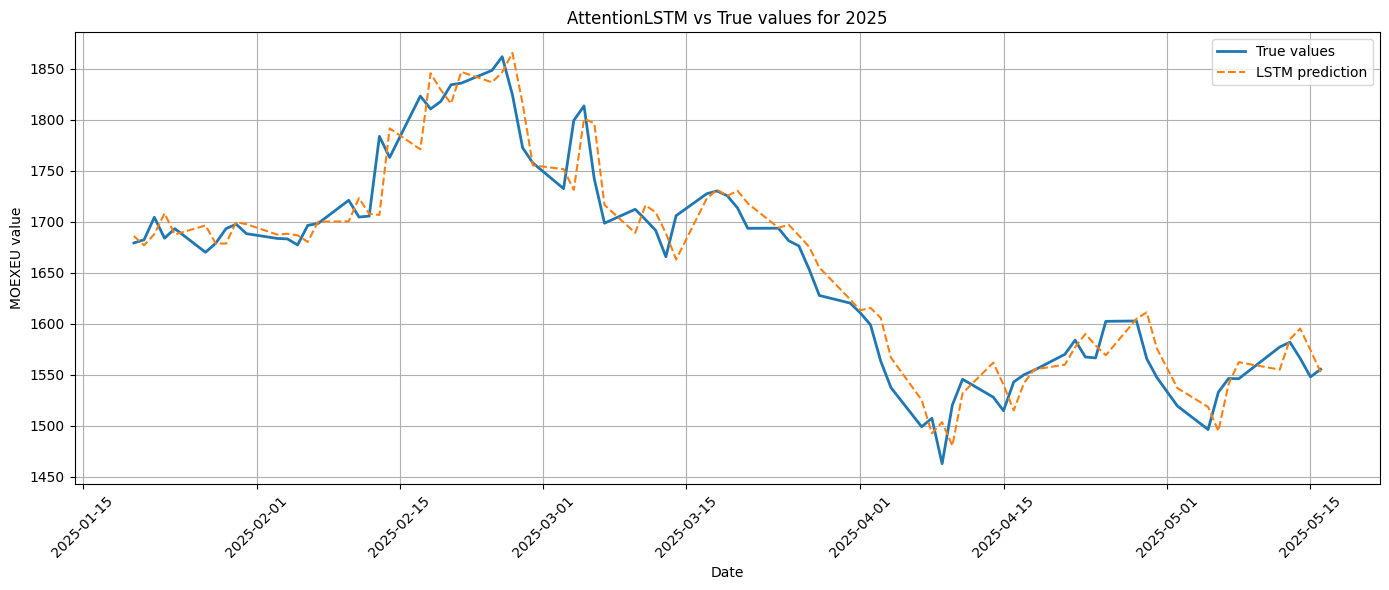

In [359]:
scaled_2025 = scaler.transform(target_moexeu_2025.reshape(-1, 1)).flatten()

X_2025, y_2025 = create_sequences(scaled_2025, seq_length)

model_a_lstm_moexeu.eval()
with torch.no_grad():
    X_tensor_2025 = torch.FloatTensor(X_2025).unsqueeze(-1).to(device)
    y_pred_2025 = model_a_lstm_moexeu(X_tensor_2025)
    if isinstance(y_pred_2025, tuple):
        y_pred_2025 = y_pred_2025[0]
    y_pred_2025 = y_pred_2025.cpu().numpy().flatten()


y_pred_2025_real = scaler.inverse_transform(y_pred_2025.reshape(-1, 1)).flatten()
y_true_2025_real = scaler.inverse_transform(y_2025.reshape(-1, 1)).flatten()


plot_dates = dates_moexeu_2025[seq_length:]  


plt.figure(figsize=(14, 6))
plt.plot(plot_dates, y_true_2025_real, label='True values', linewidth=2)
plt.plot(plot_dates, y_pred_2025_real, label='LSTM prediction', linestyle='--')
plt.title("AttentionLSTM vs True values for 2025")
plt.xlabel("Date")
plt.ylabel("MOEXEU value")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('training_plots/(MOEXEU)AttentionLSTM_vs_True_for_2025.png')


plt.show()

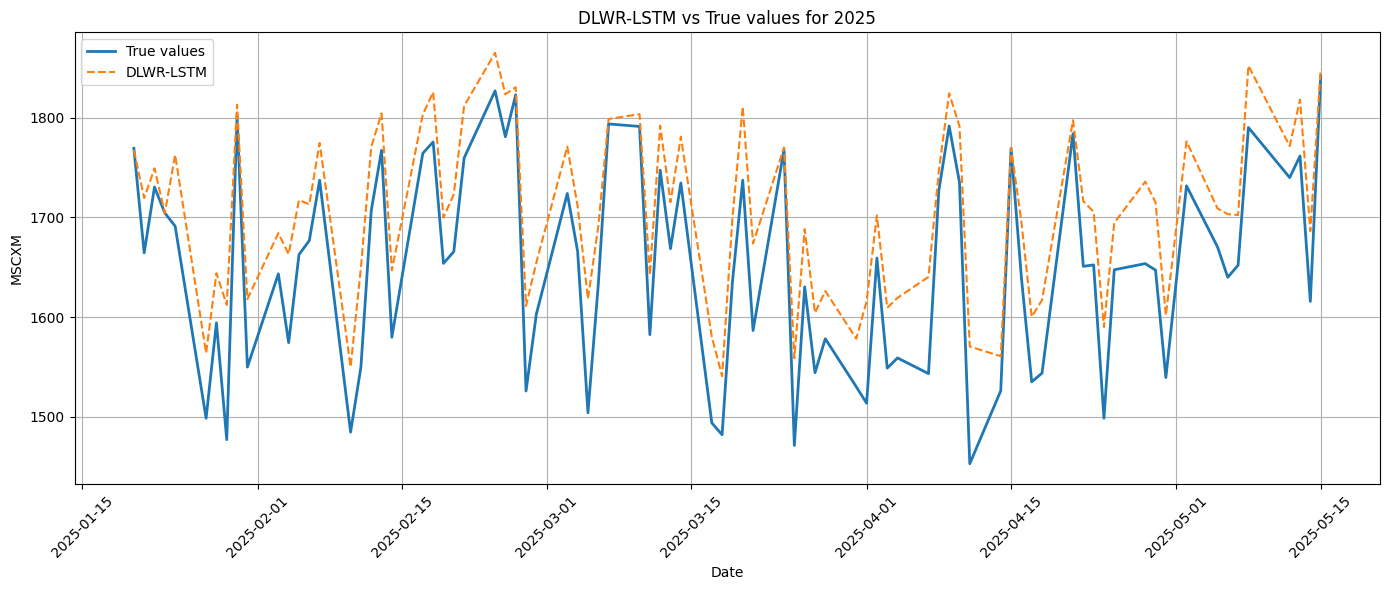

In [ ]:
components_2025 = {
    name: scalers[name].transform(series.reshape(-1, 1)).flatten()
    for name, series in zip(['f0', 'f1', 'f2', 'd2'], 
                            dlwr_trend_separation(target_mscxm_2025, 
                                                  window=window_size, 
                                                  frac=frac_param, 
                                                  separations=separations)[0] 
                            + [dlwr_trend_separation(target_mscxm_2025, 
                                                     window=window_size, 
                                                     frac=frac_param, 
                                                     separations=separations)[1]])
}

test_dlwr_2025 = create_component_loaders(components_2025, seq_length=seq_length, batch_size=1)

y_pred_dlwr = []
y_true_dlwr = []


model_dlwr_lstm.eval()
with torch.no_grad():
    iterators = {name: iter(loader) for name, loader in test_dlwr_2025.items()}
    num_batches = min(len(loader) for loader in test_dlwr_2025.values())

    for _ in range(num_batches):
        batch = {name: next(it) for name, it in iterators.items()}
        X_test = {name: data[0].to(device) for name, data in batch.items()}
        y_test = batch['f0'][1].numpy()

        output = model_dlwr_lstm(X_test['f0'], X_test['f1'], X_test['f2'], X_test['d2'])
        y_pred_dlwr.extend(output.cpu().numpy().flatten())
        y_true_dlwr.extend(y_test.flatten())

y_true_dlwr_real = scalers['f0'].inverse_transform(np.array(y_true_dlwr).reshape(-1, 1)).flatten()
y_pred_dlwr_real = scalers['f0'].inverse_transform(np.array(y_pred_dlwr).reshape(-1, 1)).flatten() 

plot_dates = dates_imoex_2025[seq_length:]

plot_dates = plot_dates[:-1]

plt.figure(figsize=(14, 6))
plt.plot(plot_dates, y_true_dlwr_real, label='True values', linewidth=2)
plt.plot(plot_dates, y_pred_dlwr_real, label='DLWR-LSTM', linestyle='--')
plt.title("DLWR-LSTM vs True values for 2025")
plt.xlabel("Date")
plt.ylabel("MSCXM")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig("training_plots/(MSCXM)DLWR-LSTM vs True values for 2025.png")

plt.show()
